In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 1s (1,045 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.1 MB/s eta 0:00:00
  Preparin

In [3]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium.wrappers import TransformReward, TransformObservation

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from typing import Tuple

from collections import deque

from river import drift

## Load Trained Policy

In [4]:
checkpoint = load_from_hub(
    repo_id = "sb3/ppo-LunarLanderContinuous-v2",
    filename = "ppo-LunarLanderContinuous-v2.zip",
)

model = PPO.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ppo-LunarLanderContinuous-v2.zip:   0%|          | 0.00/147k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


## Create Environments

In [5]:
env0 = gym.make(
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 0.0,
    turbulence_power = 1.5,
)

env1 = gym.make(
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 0.0,
    turbulence_power = 1.5,
)

env2 = gym.make(
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power = 1.5,
)

## Evaluate Policy Performance

In [6]:
evaluate_policy(model, env1, n_eval_episodes = 500)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(269.062002084636, 31.67647470369286)

In [7]:
evaluate_policy(model, env2, n_eval_episodes = 500)

(258.6373619353941, 47.408354370186245)

## Environment Drift Detection

In [8]:
rewards_production = []

env1_step = 3000
env2_step = 3000


total_step = env1_step + env2_step


n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)


env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
  replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

  rewards_production.append(r_tplus1)

  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()


rewards_production = np.array(rewards_production)

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


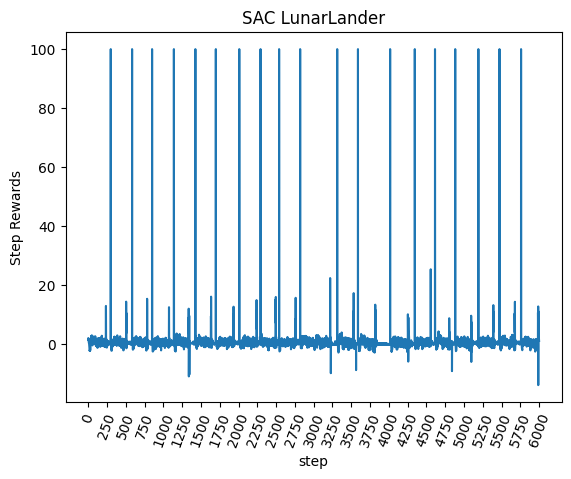

In [9]:
plt.plot(np.array(rewards_production))
plt.xlabel("step")
plt.ylabel("Step Rewards")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.title("SAC LunarLander")
plt.show()

### Environment Drift Detection with Prob CUSUM

In [10]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [11]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)


false_alarms = 0
delay = 4000

for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i<3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


In [12]:
# Environment Drift Detection with CUSUM
env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000


for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  episode_deque.append(val)
  val_avg = np.mean(episode_deque)
  p_value, drift_detected = drift_detector.predict_next(val_avg, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val_avg}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 45 with value: 0.6493320154724083
Drift Detected at: 71 with value: 0.676322895345212
Drift Detected at: 74 with value: 0.6879700561009057
Drift Detected at: 134 with value: 0.7539541294607659
Drift Detected at: 171 with value: 0.6887930699537946
Drift Detected at: 184 with value: 0.5281563133138225
Drift Detected at: 195 with value: 0.5316704231140515
Drift Detected at: 202 with value: 0.5169561040586415
Drift Detected at: 225 with value: 0.6455301698790632
Drift Detected at: 271 with value: 0.6971492071225828
Drift Detected at: 287 with value: 0.6190259053120074
Drift Detected at: 3946 with value: 0.30771315276657785
False Positives: 11, Delay: 946


### Page-Hinkley

In [13]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 4008, input value: -0.15826416858648742
False Alarms: 0, Delay: 1008


In [14]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 1077, input value: -1.0255807854903924
Change detected at index 1391, input value: -1.1006552758198163
Change detected at index 1933, input value: -0.8675315261025426
Change detected at index 2531, input value: -1.2582203824895577
Change detected at index 2768, input value: -1.0525730389610357
Change detected at index 3066, input value: -0.6571819484892276
False Alarms: 5, Delay: 66


### ADWIN

In [15]:
adwin = drift.ADWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


In [16]:
adwin = drift.ADWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 191, input value: -1.7251715322441752
Change detected at index 319, input value: -0.21162818257720092
Change detected at index 575, input value: -1.7238307361463947
Change detected at index 831, input value: -0.8419835685950274
Change detected at index 1087, input value: -1.426273343611932
Change detected at index 1375, input value: -0.9014608113698119
Change detected at index 1663, input value: -0.35181407248913343
Change detected at index 1919, input value: -1.3976602668290845
Change detected at index 2047, input value: -0.12271638130616472
Change detected at index 2239, input value: -1.420680902049615
Change detected at index 2495, input value: -1.5919755890998883
Change detected at index 2623, input value: -0.33290676104139605
Change detected at index 2783, input value: -1.643973981620382
Change detected at index 3103, input value: -1.379276067452712
False Alarms: 13, Delay: 103


### KSWIN

In [17]:
kswin = drift.KSWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 288, input value: -0.16304106170400237
Change detected at index 540, input value: -0.11543484946118236
Change detected at index 819, input value: -0.11680626732348212
Change detected at index 1113, input value: -0.10470235733846489
Change detected at index 1213, input value: -0.010675702538543344
Change detected at index 1383, input value: -0.11342092079256551
Change detected at index 1670, input value: -0.10808882342854059
Change detected at index 1770, input value: -0.14904252127639417
Change detected at index 1976, input value: -0.10023664459468522
Change detected at index 2076, input value: -0.17656535038635718
Change detected at index 2283, input value: -0.1630662355380746
Change detected at index 2482, input value: -0.34434014834058807
Change detected at index 2582, input value: -0.14046611025842387
Change detected at index 2776, input value: -0.048188632248204605
Change detected at index 2876, input value: -0.02067650158034983
Change detected at index 30

In [18]:
kswin = drift.KSWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 199, input value: -1.5234811590819937
Change detected at index 299, input value: -1.5099316861689775
Change detected at index 799, input value: -0.35768473429861947
Change detected at index 899, input value: -0.013918503090829698
Change detected at index 999, input value: -0.48039362765157095
Change detected at index 1099, input value: -1.1306300129374323
Change detected at index 1399, input value: -1.206690157983007
Change detected at index 1900, input value: -1.3889940537085732
Change detected at index 2000, input value: -1.1556003198652571
Change detected at index 2504, input value: -0.9326339321426059
Change detected at index 2604, input value: -0.17390697729231594
Change detected at index 2704, input value: -0.4814834816952569
Change detected at index 2804, input value: -1.2373242703189113
Change detected at index 3104, input value: -0.9757587410428482
False Alarms: 13, Delay: 104
